In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from datetime import datetime
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error


In [3]:
# Global Variables
target_col = 'WindSpeed 50'
train_percent = 0.66
n_past = 48
n_future = 5
n_features = 4

In [4]:
# Get data from CSV
def custom_date_parser(x): return datetime.strptime(x, "%Y %m %d %H")

dataset = pd.read_csv('MUP_dataset.csv', header=12, parse_dates=[
                      ['YEAR', 'MO', 'DY', 'HR']], date_parser=custom_date_parser, index_col=0)
dataset.index.name ='datetime'
dataset.columns = ['Pressure', 'WindSpeed 50', 'WindSpeed 10', 'Temperature']
print(dataset.head(5))


                     Pressure  WindSpeed 50  WindSpeed 10  Temperature
datetime                                                              
2016-01-01 05:00:00     98.49          6.54          3.38        18.79
2016-01-01 06:00:00     98.57          5.91          3.48        19.26
2016-01-01 07:00:00     98.66          5.74          4.70        21.07
2016-01-01 08:00:00     98.72          7.67          6.18        22.94
2016-01-01 09:00:00     98.72          8.40          6.94        24.27


In [5]:
dataset = dataset.replace('?', np.nan)
dataset.isnull().sum()


Pressure        0
WindSpeed 50    0
WindSpeed 10    0
Temperature     0
dtype: int64

In [6]:
def fill_missing(values):
    one_day = 60*24
    for row in range(dataset.shape[0]):
        for col in range(dataset.shape[1]):
            if np.isnan(values[row][col]):
                values[row, col] = values[row-one_day, col]


dataset = dataset.astype('float32')
fill_missing(dataset.values)
dataset.isnull().sum()


Pressure        0
WindSpeed 50    0
WindSpeed 10    0
Temperature     0
dtype: int64

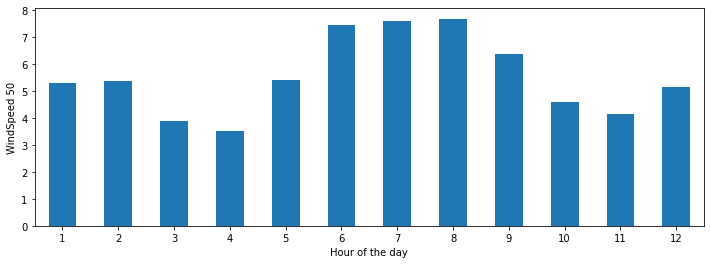

In [7]:
fig, axs = plt.subplots(figsize=(12, 4))
dataset.groupby(dataset.index.month)[
    'WindSpeed 50'].mean().plot(kind='bar', rot=0, ax=axs)
plt.xlabel("Hour of the day")
plt.ylabel(target_col)
plt.show()


In [8]:
# dataset split
TRAIN_SPLIT = int(len(dataset)*train_percent)
train_df,test_df = dataset[:TRAIN_SPLIT],dataset[TRAIN_SPLIT:]
train_df.shape,test_df.shape

((34721, 4), (17887, 4))

In [9]:
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

/var/folders/7c/546hxb311rs7g1vpllxz9r500000gn/T/ipykernel_61519/3151536076.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
/var/folders/7c/546hxb311rs7g1vpllxz9r500000gn/T/ipykernel_61519/3151536076.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
/var/folders/7c/546hxb311rs7g1vpllxz9r500000gn/T/ipykernel_61519/3151536076.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [10]:
print(train)

                     Pressure  WindSpeed 50  WindSpeed 10  Temperature
datetime                                                              
2016-01-01 05:00:00  0.506020     -0.423519     -0.619863    -0.770270
2016-01-01 06:00:00  0.602402     -0.479222     -0.608447    -0.730574
2016-01-01 07:00:00  0.710846     -0.494253     -0.469178    -0.577703
2016-01-01 08:00:00  0.783127     -0.323607     -0.300228    -0.419763
2016-01-01 09:00:00  0.783127     -0.259063     -0.213470    -0.307432
...                       ...           ...           ...          ...
2019-12-17 17:00:00  0.072281     -0.283820     -0.396119    -0.268581
2019-12-17 18:00:00  0.204811     -0.280283     -0.399543    -0.323480
2019-12-17 19:00:00  0.313255     -0.267020     -0.388128    -0.354730
2019-12-17 20:00:00  0.373489     -0.240495     -0.358447    -0.375000
2019-12-17 21:00:00  0.397591     -0.248453     -0.358447    -0.398649

[34721 rows x 4 columns]


In [87]:
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [88]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(34669, 48, 4) (34669, 5, 4)
(17835, 48, 4) (17835, 5, 4)


In [89]:
# E1D1
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

#
model_e1d1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 48, 4)]      0           []                               
                                                                                                  
 lstm_6 (LSTM)                  [(None, 100),        42000       ['input_3[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 repeat_vector_2 (RepeatVector)  (None, 5, 100)      0           ['lstm_6[0][0]']                 
                                                                                            

In [90]:
# E2D2
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e2d2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 48, 4)]      0           []                               
                                                                                                  
 lstm_8 (LSTM)                  [(None, 48, 100),    42000       ['input_4[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 lstm_9 (LSTM)                  [(None, 100),        80400       ['lstm_8[0][0]']                 
                                 (None, 100),                                               

In [91]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=1,callbacks=[reduce_lr])

model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=1,callbacks=[reduce_lr])

Epoch 1/25


2022-04-19 16:02:30.215720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-19 16:02:30.451013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-19 16:02:30.524011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-19 16:02:30.585335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-19 16:02:30.651442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1084/1084 [==============================] - ETA: 0s - loss: 0.0058

2022-04-19 16:02:50.690039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-19 16:02:50.761218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-19 16:02:50.820764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1084/1084 [==============================] - 27s 23ms/step - loss: 0.0058 - val_loss: 0.0024 - lr: 0.0010
Epoch 2/25
1084/1084 [==============================] - 25s 23ms/step - loss: 0.0024 - val_loss: 0.0021 - lr: 9.0000e-04
Epoch 3/25
1084/1084 [==============================] - 25s 23ms/step - loss: 0.0020 - val_loss: 0.0019 - lr: 8.1000e-04
Epoch 4/25
1084/1084 [==============================] - 25s 23ms/step - loss: 0.0019 - val_loss: 0.0017 - lr: 7.2900e-04
Epoch 5/25
1084/1084 [==============================] - 25s 23ms/step - loss: 0.0017 - val_loss: 0.0017 - lr: 6.5610e-04
Epoch 6/25
1084/1084 [==============================] - 25s 23ms/step - loss: 0.0016 - val_loss: 0.0017 - lr: 5.9049e-04
Epoch 7/25
1084/1084 [==============================] - 25s 23ms/step - loss: 0.0015 - val_loss: 0.0016 - lr: 5.3144e-04
Epoch 8/25
1084/1084 [==============================] - 25s 23ms/step - loss: 0.0015 - val_loss: 0.0015 - lr: 4.7830e-04
Epoch 9/25
1084/1084 [=========================

2022-04-19 16:13:00.072202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-19 16:13:00.467490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-19 16:13:00.554269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-19 16:13:00.629362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-19 16:13:00.674227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-19 16:13:00.737180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-19 16:13:00.810834: I tensorflow/core/grappler/optimizers/cust

1084/1084 [==============================] - ETA: 0s - loss: 0.0066

2022-04-19 16:13:33.993334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-19 16:13:34.121415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-19 16:13:34.197987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-19 16:13:34.262827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-19 16:13:34.295125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1084/1084 [==============================] - 44s 38ms/step - loss: 0.0066 - val_loss: 0.0029 - lr: 0.0010
Epoch 2/25
1084/1084 [==============================] - 40s 37ms/step - loss: 0.0026 - val_loss: 0.0022 - lr: 9.0000e-04
Epoch 3/25
1084/1084 [==============================] - 40s 37ms/step - loss: 0.0021 - val_loss: 0.0020 - lr: 8.1000e-04
Epoch 4/25
1084/1084 [==============================] - 40s 36ms/step - loss: 0.0018 - val_loss: 0.0018 - lr: 7.2900e-04
Epoch 5/25
1084/1084 [==============================] - 40s 37ms/step - loss: 0.0017 - val_loss: 0.0016 - lr: 6.5610e-04
Epoch 6/25
1084/1084 [==============================] - 40s 37ms/step - loss: 0.0016 - val_loss: 0.0016 - lr: 5.9049e-04
Epoch 7/25
1084/1084 [==============================] - 40s 37ms/step - loss: 0.0015 - val_loss: 0.0016 - lr: 5.3144e-04
Epoch 8/25
1084/1084 [==============================] - 40s 37ms/step - loss: 0.0014 - val_loss: 0.0015 - lr: 4.7830e-04
Epoch 9/25
1084/1084 [=========================

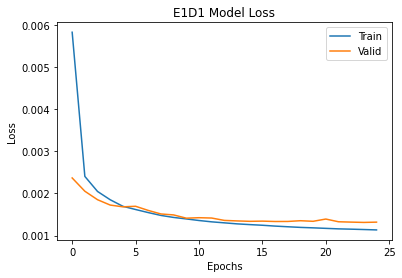

In [92]:
plt.plot(history_e1d1.history['loss'])
plt.plot(history_e1d1.history['val_loss'])
plt.title("E1D1 Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

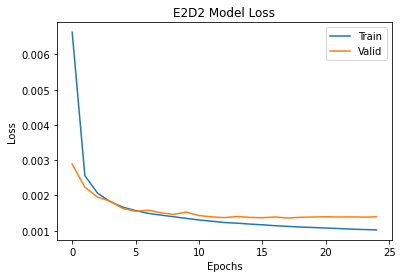

In [93]:
plt.plot(history_e2d2.history['loss'])
plt.plot(history_e2d2.history['val_loss'])
plt.title("E2D2 Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

In [94]:
pred1_e1d1=model_e1d1.predict(X_test)
pred1_e2d2=model_e2d2.predict(X_test)

pred_e1d1=model_e1d1.predict(X_train)
pred_e2d2=model_e2d2.predict(X_train)

2022-04-19 16:29:45.033743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-19 16:29:45.096737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-19 16:29:45.210197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-19 16:29:50.493251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-19 16:29:50.611925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-19 16:29:50.681054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-19 16:29:50.760729: I tensorflow/core/grappler/optimizers/cust

In [95]:
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    pred1_e1d1[:,:,index]=scaler.inverse_transform(pred1_e1d1[:,:,index])
    pred_e1d1[:,:,index]=scaler.inverse_transform(pred_e1d1[:,:,index])
    
    pred1_e2d2[:,:,index]=scaler.inverse_transform(pred1_e2d2[:,:,index])
    pred_e2d2[:,:,index]=scaler.inverse_transform(pred_e2d2[:,:,index])
    
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

In [ ]:

index = 1
print(train_df.columns[index])
for j in range(1,6):
  print("Hour ",j,":")
  print("MAE-E1D1 : ",np.sqrt(mean_squared_error(y_test[:,j-1,index],pred1_e1d1[:,j-1,index])),end=", ")
  print("MAE-E2D2 : ",np.sqrt(mean_squared_error(y_test[:,j-1,index],pred1_e2d2[:,j-1,index])))